# pyWATVina (Python API for watvina) 教程

## pyWATVina的安装流程：

**pyWATVina的安装较为复杂，请按照以下流程安装** 

1. **解压 pywatvina.zip**

`unzip pywatvina.zip`

2. **解压 pywatvina的静态库**

`cd watvina`

`ar -x libwatvina.a`

该步骤会生成若干的 `.o` 格式的文件

3. **重新编译成动态库，以便python调用**

**注意要在自己python环境下的boost版本 **

`g++ -pthread -shared -Wl,-O1 -Wl,-Bsymbolic-functions -Wl,-Bsymbolic-functions -Wl,-z,relro -g -fwrapv -O2 -Wl,-Bsymbolic-functions -Wl,-z,relro -g -fwrapv -O2 -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 *.o -o _watvina_wrapper.so -lboost_thread -lboost_serialization -lboost_filesystem -lboost_program_options`

该步骤会生成 `_watvina_wrapper.so` 动态库

4. **删除不必要的文件** 

`$rm *.a *.o`

5. **将本文件夹`watvina`拷贝到python环境**

一般是 `${你的python环境下lib/python3.x/dist-pakcages/}`

In [3]:
# Step 1: 加载watvina模块和rdkit2pdbqt.py的函数
from watvina.watvina_wrapper import WATVina
from watvina.rdkit2pdbqt import *
from rdkit.Geometry import Point3D

In [4]:
# Step 2: 建立一个对接任务，采用8个cpu核
wv=WATVina(8,0,1)

In [5]:
#从pdb文件读取受体
receptor_mol=Chem.MolFromPDBFile("rec.pdb", removeHs=False)
receptor_lines=MolToPDBQTBlock(receptor_mol, False, False, True)
wv.set_receptor_from_string(receptor_lines)

In [6]:
# Step 2.x:  读取水，或者药效团设置
#wv.set_pharmacophore_from_file("pharm.txt")
#wv.set_water("water.pdb",implicitsol=False)

In [7]:
# Step 3: 设置打分权重和格点
wv.set_watvina_weights(weight_vdw=0.184,weight_hb=1.00,weight_elep=0.15)
wv.set_extra_constraints(weight_desol=-0.500, wclash_dist=0.500, weight_torsion=0.300)
wv.set_grid_dims(center_x=0.55,center_y=30,center_z=16.5,size_x=19,size_y=23,size_z=23,granularity=0.375)

In [8]:
#Step 4: 根据打分方程预先计算不同距离的打分, 这个在global_search，score, optimize, relax时候都需要
#不带参数则只储存配体原子类型的格点能量
#wv.set_precalculate_sf()
#watvina的格点能量计算需要点时间, 所以我们如果针对不同的配体最好预先计算所有原子类型
wv.set_precalculate_sf(prec_full_atomtypes=True)

In [9]:
#计算所有原子类型的格点
#后面所有的配体都可以用这一个格点能量，不需要重复计算
%time
wv.compute_watvina_maps()

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 6.91 µs
Computing WATVina grid ... done.


In [10]:
#Step 5 : 从sdf文件中读取配体
ligand_mol=Chem.MolFromMolFile("i.sdf",removeHs=False)
ligand_lines=MolToPDBQTBlock(ligand_mol, True, False, True)
wv.set_ligand_from_string(ligand_lines)
wv.pose_atomids=[x-1 for x in wv.pose_atomids]
#wv.pose_atomids

In [11]:
wv.global_search(exhaustiveness=8,n_poses=3,min_rmsd=1.5,energy_range=3,population_size=8,
                 ga_searching=4,refinement=True, tramplitude=1.00)

Using random seed: -767072498
Performing search ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************
done.
Refining results ... done.


In [17]:
print(f'Num of Docked Confs:{len(wv.poses_score)}')
print(f'Num of Atoms: {ligand_mol.GetNumAtoms()}')
print(f'Num of Atoms 2: {len(wv.poses_coords[0])}')
#wv.poses_coords[0]
#wv.pose_atomids

Num of Docked Confs:3
Num of Atoms: 58
Num of Atoms 2: 58


In [34]:
#写出结果
def mol_output(mol, wv_obj, output_writer):
    for confid in range(mol.GetNumConformers()):
        if confid > 0:
            mol.RemoveConformer(confid)
    
    conf = Chem.Conformer(mol.GetNumAtoms())
    #conf = mol.GetConformer(0)
    assert len(wv_obj.pose_atomids) == len(wv_obj.poses_coords[0])     
    for pose_id in range(len(wv_obj.poses_coords)):
        for atomid,coord in zip(wv_obj.pose_atomids,wv_obj.poses_coords[pose_id]):
            conf.SetAtomPosition(atomid,coord)    
        conf_id   = pose_id + 1
        conf_score='%.2f' % wv_obj.poses_score[pose_id]

        conf_vdw='%.2f' % wv_obj.poses_vdw[pose_id]
        conf_hbond='%.2f' % wv_obj.poses_hbond[pose_id]
        conf_electrop='%.2f' % wv_obj.poses_electrop[pose_id] 
            
        mol.SetProp('ConfID', f'{conf_id}')
        mol.SetProp("Score",conf_score)
        mol.SetProp("VDW",conf_vdw)
        mol.SetProp("Hbond",conf_hbond)
        mol.SetProp("Electrop",conf_electrop)
        
        conf.SetProp('ConfID', f'{conf_id}')
        conf.SetProp("Score",conf_score)
        conf.SetProp("VDW",conf_vdw)
        conf.SetProp("Hbond",conf_hbond)
        conf.SetProp("Electrop",conf_electrop)
        #原先mol有默认的conf 0
        #然后在这个基础上添加新的构象
        mol.AddConformer(conf,assignId=True)  #在poseid + 1
        #print(f'mol contains conformer: {mol.GetNumConformers()}')
        output_writer.write(mol,confId=conf_id) #conf_id 是 pose_id + 1

In [35]:
output_writer =Chem.SDWriter('i_out.sdf')
mol_output(ligand_mol, wv, output_writer)

mol contains conformer: 2
mol contains conformer: 3
mol contains conformer: 4


In [27]:
ligand_mol.GetNumConformers()

13

In [17]:
# working with multiple mols in sdf
ligandMols = Chem.SDMolSupplier('ligs.sdf', removeHs=False)
output_writer =Chem.SDWriter('ligs_out.sdf')
for idx, molx in enumerate(ligandMols):
    try:
        Chem.SanitizeMol(molx)
        ligand_pdbqt=MolToPDBQTBlock(molx, True, False, True)
        wv.set_ligand_from_string(ligand_pdbqt)
        wv.pose_atomids=[x-1 for x in wv.pose_atomids]
        wv.global_search(exhaustiveness=8,n_poses=3,min_rmsd=1.5,energy_range=3,population_size=8,
                 ga_searching=4,refinement=True, tramplitude=1.00)
        mol_output(molx, wv, output_writer)
    except Exception as inst:
        print(f'ligand {idx} with Error: {inst} ')
        
  

+-----------+-------------+------------------------------------------------+
| summary   |   RMSD_TO   |               Score contribution               |
+---+-------+------+------+-------+-------+-------+-------+-------+--------+
|No.| score | best | init |  VDW  | HBond | Elect | Desol | Clash | Torsion|
+---+-------+------+------+-------+-------+-------+-------+-------+--------+
!  1  -8.40   0.00   0.38  -48.13   -1.53   -2.83    0.00    0.50    0.08
!  2  -8.36   1.38   1.39  -47.58   -1.59   -2.84    0.00    0.51    0.11
!  3  -8.25   2.24   2.40  -43.68   -1.85   -3.27    0.00    0.66    0.13
Using random seed: -907894400
Performing search ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************
done.
Refining results ... done.
+-----------+-------------+------------------------------------------------+
| summary   |   RMSD_TO   |               Score contribution           

In [13]:
#Step 5.x1 只给初始构象打分
#wv.score()

In [14]:
#Step 5.x2 只对初始构象进行松弛(relax)
#wv.relax_structure(relax_steps=1000, tramplitude=0.001, rotamplitude=1.00)

In [15]:
#Step 5.x3 只对初始构象进行局部优化
#wv.optimize(max_steps=100)
#wv.score()

interactive(children=(IntSlider(value=1, description='confId', max=6, min=1), Output()), _dom_classes=('widget…

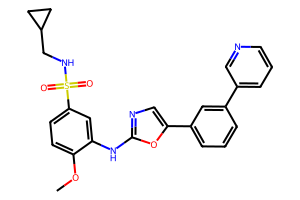

In [20]:
#关于对接后的构象的浏览
import py3Dmol
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import DrawingOptions
from ipywidgets import interact, interactive, fixed

#定义展示分子各个构象的3D结构的函数
def viewlig(ligmol,view3d,confId=-1):
        ligmolblock = Chem.MolToMolBlock(ligmol,confId=confId)
        view3d.removeAllModels()
        view3d.addModel(ligmolblock,'sdf')
        view3d.setStyle({'stick':{}})
        view3d.setBackgroundColor('0xeeeeee')
        view3d.zoomTo()
        return view3d.show()

#交互式展示对接后的构象3D结构
view3d = py3Dmol.view(width=300,height=200)
interact(viewlig, ligmol=fixed(ligand_mol),view3d=fixed(view3d),
         confId=(1,ligand_mol.GetNumConformers()-1));

#展示配体分子2D结构
DrawingOptions.atomLabelFontSize = 80
DrawingOptions.dotsPerAngstrom = 150
DrawingOptions.bondLineWidth = 2.0

ligmol2d = Chem.RemoveHs(ligand_mol)
ligmol2d.RemoveAllConformers()
Draw.MolToImage(ligmol2d, size=(300, 200))

In [22]:
#分析构象1和蛋白的相互作用，该案例用的是prolif
#分析构象1和蛋白的相互作用，该案例用的是prolif
import prolif as plf #加载prolif包，简称plf

protmol_plf = plf.Molecule.from_rdkit(receptor_mol)
ligmol_tmp = Chem.Mol(ligand_mol,confId=1) # rdkit的分子对象
ligmol_plf=plf.Molecule.from_rdkit(ligmol_tmp) #将rdkit的分子对象转换为prolif的分子对象
fp = plf.Fingerprint()
fp.run_from_iterable([ligmol_plf], protmol_plf)
df=fp.to_dataframe()
df.T

  0%|          | 0/1 [00:00<?, ?it/s]

Frame                            0
ligand protein   interaction      
UNL1   LEU838.A  Hydrophobic  True
                 VdWContact   True
       VAL846.A  Hydrophobic  True
       ALA864.A  Hydrophobic  True
       LYS866.A  Hydrophobic  True
                 VdWContact   True
       GLU883.A  VdWContact   True
       VAL912.A  Hydrophobic  True
       VAL914.A  Hydrophobic  True
                 VdWContact   True
       GLU915.A  VdWContact   True
       PHE916.A  Hydrophobic  True
                 VdWContact   True
       CYS917.A  Hydrophobic  True
                 HBAcceptor   True
                 VdWContact   True
       LYS918.A  VdWContact   True
       GLY920.A  VdWContact   True
       ASN921.A  HBAcceptor   True
                 VdWContact   True
       LEU1033.A Hydrophobic  True
       PHE1045.A Hydrophobic  True
                 PiStacking   True

In [23]:
#相互作用可视化
fp_count = plf.Fingerprint(count=True)
fp_count.run_from_iterable([ligmol_plf], protmol_plf)
fp_count.plot_lignetwork(ligmol_plf, kind="frame", frame=0, display_all=True)

  0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
view = fp_count.plot_3d(ligmol_plf, protmol_plf, frame=0, display_all=False)
view

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [25]:
#读取第二个分子
ligand_mol=Chem.MolFromMolFile("2.sdf",removeHs=False)
ligand_lines=MolToPDBQTBlock(ligand_mol, True, False, True)
wv.set_ligand_from_string(ligand_lines)
wv.pose_atomids=[x-1 for x in wv.pose_atomids]
#wv.pose_atomids

In [29]:
#直接全局搜索构象
%time
wv.global_search(exhaustiveness=8,n_poses=9,min_rmsd=1.5,energy_range=3,
                 population_size=8,ga_searching=4,refinement=True)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs
+-----------+-------------+------------------------------------------------+
| summary   |   RMSD_TO   |               Score contribution               |
+---+-------+------+------+-------+-------+-------+-------+-------+--------+
|No.| score | best | init |  VDW  | HBond | Elect | Desol | Clash | Torsion|
+---+-------+------+------+-------+-------+-------+-------+-------+--------+
!  1  -7.45   0.00   0.37  -37.65   -1.44   -2.41    0.00    0.30    0.05
!  2  -7.16   1.04   1.07  -35.36   -1.53   -2.96    0.00    0.36    0.14
!  3  -6.01   1.91   1.88  -34.53   -0.98   -1.50    0.00    0.42    0.20
!  4  -5.96   2.49   2.42  -35.25   -0.67   -2.42    0.00    0.07    0.67
!  5  -5.79   1.33   1.27  -35.49   -0.03   -3.59    0.00    0.14    0.48
!  6  -5.69   4.75   4.70  -30.87   -1.22   -2.21    0.00    0.06    0.69
!  7  -5.56   4.94   4.93  -32.34   -0.67   -2.12    0.00    0.33    0.27
!  8  -5.56   5.12   5.15  -32.10

In [28]:
#这个坐标集是第2个分子了
#所有的pose的坐标都保存在wv.poses_coords中
len(wv.poses_coords)

9

In [30]:
#第2个分子对接后构象的打分
#所有pose的打分保存
wv.poses_score

(-7.487720966339111,
 -7.195178985595703,
 -5.909019470214844,
 -5.744069576263428,
 -5.71523380279541,
 -5.6176652908325195,
 -5.583613872528076,
 -5.497421741485596,
 -5.445540904998779)

In [31]:
#vdw
#所有pose的vdw打分
wv.poses_vdw

(-37.527503967285156,
 -35.328125,
 -33.65629959106445,
 -32.376556396484375,
 -31.17197036743164,
 -31.325883865356445,
 -33.36445617675781,
 -33.47499084472656,
 -34.47392654418945)

In [32]:
#hbond
#所有pose的氢键打分
wv.poses_hbond

(-1.4859615564346313,
 -1.5394397974014282,
 -1.0286657810211182,
 -0.4522096514701843,
 -1.2276991605758667,
 -0.6929499506950378,
 -0.7289711236953735,
 -0.4968006908893585,
 -0.23631352186203003)

In [33]:
#electrop
#所有的pseudo_elec打分
wv.poses_electrop

(-2.398615837097168,
 -2.9382433891296387,
 -1.1456652879714966,
 -3.1689491271972656,
 -2.2021031379699707,
 -1.918542504310608,
 -1.5223984718322754,
 -2.1861648559570312,
 -2.3646552562713623)

In [34]:
#the rmsd to the initial conformation
wv.poses_rmsdinit

(0.25161340832710266,
 1.040609359741211,
 2.0511279106140137,
 4.970569610595703,
 4.7658305168151855,
 5.067173004150391,
 5.153854846954346,
 4.915577411651611,
 3.470320224761963)